In [1]:
import cv2
import pickle
import matplotlib.pyplot as plt

# Load calibration data
with open("./data/stereo_calibration.pkl", "rb") as f:
    data = pickle.load(f)

print(data.keys())

cameraMatrix1 = data['left_K']
distCoeffs1   = data['left_dist']
cameraMatrix2 = data['right_K']
distCoeffs2   = data['right_dist']
R             = data['R']
T             = data['T']
image_size    = data['image_size']

# Compute rectification transforms
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    cameraMatrix1,
    distCoeffs1,
    cameraMatrix2,
    distCoeffs2,
    image_size,
    R,
    T,
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=-1
)

# print("P1:\n", P1)
# print("P2:\n", P2)


dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])


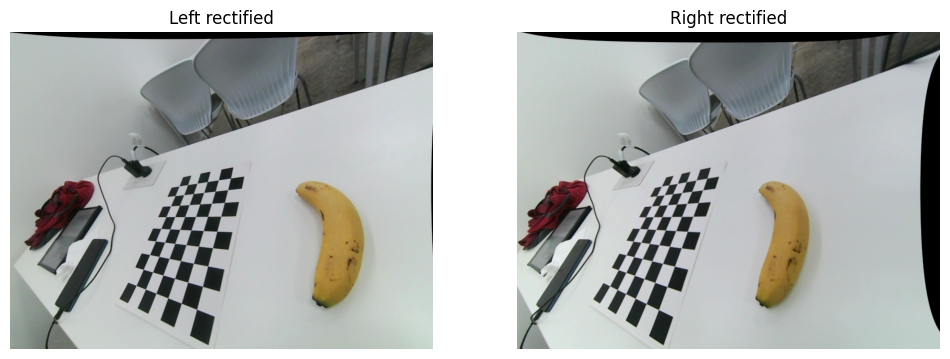

(np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5))

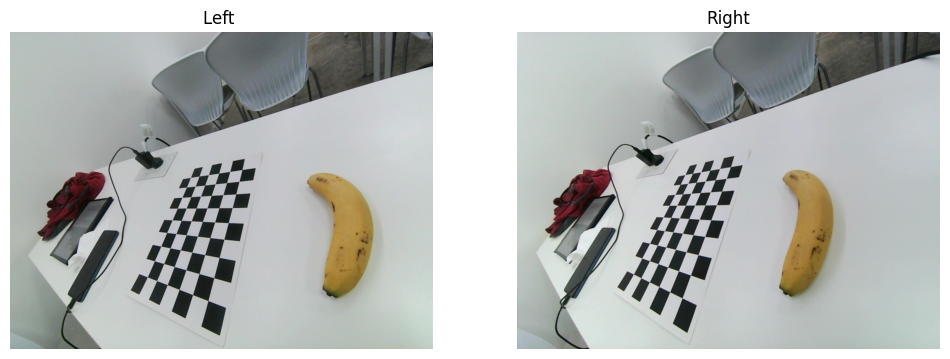

In [2]:
# Mapas de rectificación (izquierda y derecha)
left_image=cv2.imread("./fotos_objetos/left_2.jpg")
right_image=cv2.imread("./fotos_objetos/right_2.jpg")

left_image  = cv2.cvtColor(left_image,  cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)

map1x, map1y = cv2.initUndistortRectifyMap(
    cameraMatrix1, distCoeffs1, R1, P1, image_size, cv2.CV_32FC1
)

map2x, map2y = cv2.initUndistortRectifyMap(
    cameraMatrix2, distCoeffs2, R2, P2, image_size, cv2.CV_32FC1
)

# Aplicar los mapas a las imágenes
left_rectified  = cv2.remap(left_image,  map1x, map1y, cv2.INTER_LINEAR)
right_rectified = cv2.remap(right_image, map2x, map2y, cv2.INTER_LINEAR)

# with open("./data/stereo_maps.pkl", "rb") as f:
#     maps = pickle.load(f)

# left_map_x = maps["left_map_x"]
# left_map_y = maps["left_map_y"]
# right_map_x = maps["right_map_x"]
# right_map_y = maps["right_map_y"]

# left_rectified  = cv2.remap(left_image,  left_map_x,  left_map_y,  cv2.INTER_LINEAR)
# right_rectified = cv2.remap(right_image, right_map_x, right_map_y, cv2.INTER_LINEAR)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_rectified)
plt.title("Left rectified")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(right_rectified)
plt.title("Right rectified")
plt.axis("off")

plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_image)
plt.title("Left ")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(right_image)
plt.title("Right")
plt.axis("off")

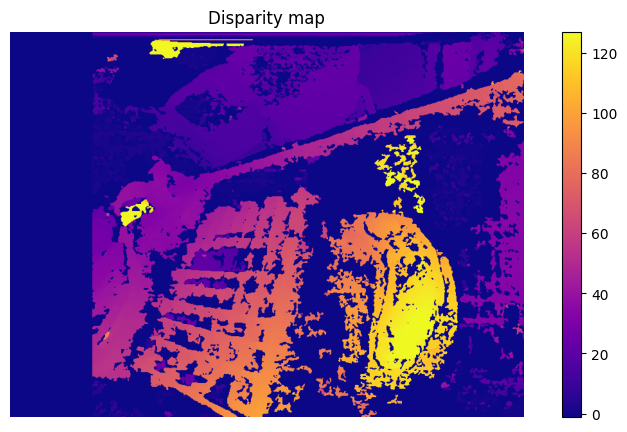

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Create StereoSGBM matcher
window_size = 5
min_disp = 0
num_disp = 16*8  # must be divisible by 16

stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=window_size,
    P1=8*3*window_size**2,
    P2=32*3*window_size**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

disparity = stereo.compute(left_rectified, right_rectified).astype(np.float32) / 16.0

# Optional: normalize for visualization
plt.figure(figsize=(10, 5))
plt.imshow(disparity, cmap='plasma')
plt.colorbar()
plt.title("Disparity map")
plt.axis('off')
plt.show()



In [4]:
# en esta celda se extraen los parametros del stereo_calibration.pkl para poder hacer lo de la tutorial 6

with open("./data/stereo_calibration.pkl", "rb") as f:
    calib = pickle.load(f)

# Intrinsic matrices
K1 = calib['left_K']
K2 = calib['right_K']

# K = [[fx, 0, cx],
#      [0, fy, cy],
#      [0,  0,  1]]

fx  = K1[0, 0]
fy  = K1[1, 1]
cx0 = K1[0, 2]  # principal point x of left camera
cy0 = K1[1, 2]  # principal point y of left camera

# cx1 is from the rectified right projection matrix P2
# Compute rectification first:
R = calib['R']
T = calib['T']
image_size = calib['image_size']
dist1 = calib['left_dist']
dist2 = calib['right_dist']

R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
    K1, dist1,
    K2, dist2,
    image_size, R, T,
    flags=cv2.CALIB_ZERO_DISPARITY, alpha=0
)

cx1 = P2[0, 2]  # principal point x of rectified right camera


models/crestereo_combined_iter5_720x1280.onnx


/home/myo/Documents/Vision/tps/tp2/tp2_reconstruccion_3d/.venv/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


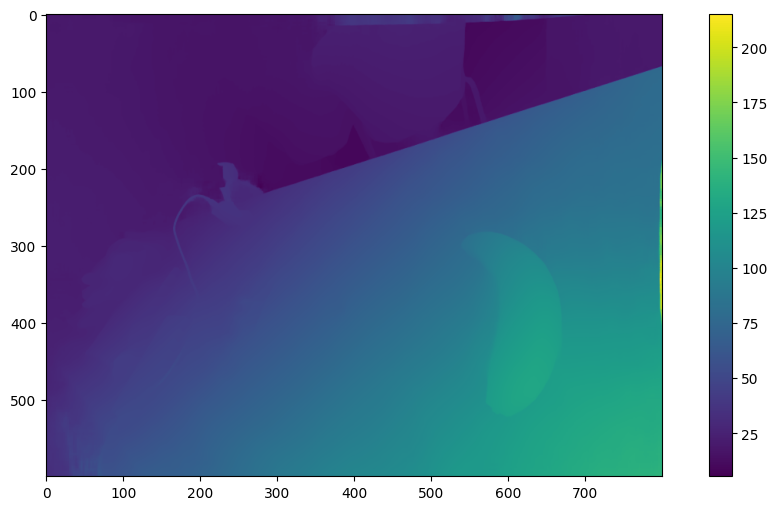

In [5]:
# copiado y pegado de la tutorial 6


w, h = left_image.shape[1], left_image.shape[0]

# fx = left_K[0][0]
# fy = left_K[1][1]
# cx0 = left_K[0][2]
# cy0 = left_K[1][2]

baseline = np.linalg.norm(T)



# Cre Stereo

import cv2
import json
import numpy as np
from pathlib import Path


from disparity.method_cre_stereo import CREStereo
from disparity.method_opencv_bm import StereoBM, StereoSGBM
from disparity.methods import Calibration, InputPair, Config


calibration = Calibration(**{
    "width": w,
    "height": h,
    "baseline_meters": baseline / 1000,
    "fx": fx,
    "fy": fy,
    "cx0": cx0,
    "cx1": cx0,
    "cy": cy0,
    "depth_range": [0.05, 20.0],
    "left_image_rect_normalized": [0, 0, 1, 1]
})



import os

models_path = "models"
if not os.path.exists(models_path):
    os.makedirs(models_path)




#models_path = Path.home() / ".cache" / "stereodemo" / "models"
models_path = Path(models_path)
pair = InputPair(left_rectified, right_rectified, calibration)
# pair = InputPair(left_image, right_image, calibration)
config = Config(models_path=models_path)

# params = {
#    "Shape": "1280x720",
#    "Mode": "combined",
#    "Iterations": 20
#}
method = CREStereo(config)

#method.parameters["Shape"].set_value("640x480")
method.parameters["Shape"].set_value("1280x720")
# method.parameters["Iterations"].set_value("10")

#method.parameters.update(params)
# method = StereoBM(config)
# method = StereoSGBM(config)
# method = StereoBM(config)
disparity = method.compute_disparity(pair)





plt.figure(figsize=(12, 6))
plt.imshow(disparity.disparity_pixels)
plt.colorbar()
plt.show()

In [6]:
with open("./data/stereo_calibration.pkl", "rb") as f:
    calib = pickle.load(f)
print(calib.keys())

dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])


In [7]:
with open("./data/stereo_maps.pkl", "rb") as f:
    calib = pickle.load(f)
print(calib.keys())

dict_keys(['left_map_x', 'left_map_y', 'right_map_x', 'right_map_y', 'R1', 'R2', 'P1', 'P2', 'Q', 'validRoi1', 'validRoi2'])


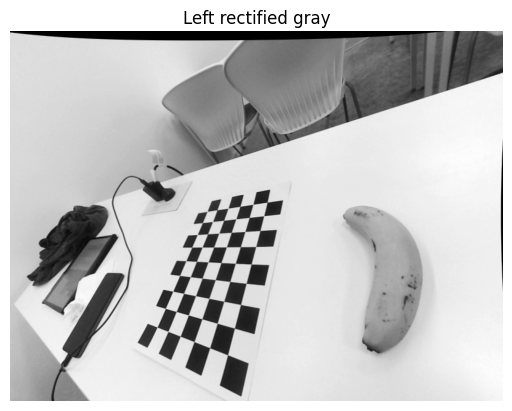

Found corners: False
Corners shape: None


error: OpenCV(4.12.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:835: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) || (npoints >= 3 && flags == SOLVEPNP_SQPNP) ) && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPGeneric'


In [8]:
# copypaste del pdf consigna, seccion 5

import calib
checkerboard=(9,5)
cuadradito_size_mm=20
left_rectified_gray=cv2.cvtColor(left_rectified,cv2.COLOR_RGB2GRAY)
left_rectified_gray = left_rectified_gray.astype(np.uint8)

plt.imshow(left_rectified_gray,cmap='gray')
plt.title("Left rectified gray")
plt.axis("off")
plt.show()

left_found,left_corners=calib.detect_board(checkerboard,left_rectified_gray)

print(f"Found corners: {left_found}")
print(f"Corners shape: {left_corners}")

object_3dpoints=calib.board_points(checkerboard)
object_3dpoints_mm=object_3dpoints*cuadradito_size_mm

ret,rvec,tvec=cv2.solvePnP(object_3dpoints_mm,left_corners,K1,dist1,flags=cv2.SOLVEPNP_IPPE)